In [1]:
from covid.simulator import Population
from covid.auxilliary import symptom_names
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from covid.policy import Policy

In [2]:
symptom_names = ['covid_recovered','covid_positive', 'no_taste_smell',
'fever','headache', 'pneumonia','stomach','myocarditis', 'blood_clots','death']


In [3]:
w = np.array([0.2, 0.1, 0.1, 0.1, 0.5, 0.2, 0.5, 1.0, 100])
assert w.shape[0] == 9, 'Shape of weights does not fit number of symptoms'

In [4]:
class BetaBernoulliModel:
    def __init__(self, nsymptom, nvacc):
        # Priors for the beta-bernoulli model
        self.a = np.ones(shape=[nvacc, nsymptom])/2 # using jeffreys prior
        self.b = np.ones(shape=[nvacc, nsymptom])/2 # using jeffreys prior
        self.nvacc = nvacc
        self.nsymptom = nsymptom

    def update(self, features, actions, outcomes):
        """
        for index in range(self.nvacc):
            print(outcomes[np.where(actions == (index-1))]) 
            print(actions)
            print(outcomes)
            if (np.sum(outcomes[np.where(actions == index - 1)], axis=1).size != 0):
                self.a[index] += np.sum(outcomes[np.where(actions == index - 1)], axis=1)
                self.b[index] += np.sum(outcomes[np.where(actions == index - 1)]==0, axis=1)\
                    - np.sum(outcomes[np.where(actions == index - 1)], axis=1)
            else: 
                self.b[index] += np.sum((outcomes==0)[np.where(actions == index - 1)], axis=1)
        """

        # performing the update to the beta - Bernoulli model for each case
        # in a loop. i.e. when |y| = 1
        # TODO: vecotirze this / fix the code above
        for index, outcome in enumerate(outcomes):
            self.a[int(actions[index])] += outcome[1:]
            self.b[int(actions[index])] += 1 - outcome[1:]

    def get_params(self):
        # Returns the parameters of all the beta distrobutions.
        return self.a, self.b


    def get_prob(self, features, action):
        # Returns the maximum posterior estiamte / mean of the theta-distrobution
        # which is a/(a+b) where a and b are the posterior parameters
        return self.a[action] / (self.a[action] + self.b[action])

    
    def retrain(self, features, actions, outcomes):
        # Retrains the model using jeffreys prior. The input should be the complete 
        # database of the trials etc. (This overwrites the old model)
        # With no privacy guarantee, this is equivivalent to continously update the model
        # However if we add laplace noise, then this would be a centralized method
        # as opposed to the local method which 'update' employs

        self.a = np.ones(shape=[self.nvacc, self.nsymptom])/2 # using jeffreys prior
        self.b = np.ones(shape=[self.nvacc, self.nsymptom])/2 # using jeffreys prior

        self.update(features, actions, outcomes)

In [5]:
class Naive(Policy):
    def get_utility(self, features, action, outcome):
        utility = 0
        for t, o in enumerate(outcome):
            utility -= np.dot(w, o[1:])*(1+int(action[t] != -1))
       
        return utility

    def set_model(self, model):
        self.model = model
    
    def get_action(self, features):
        """Get a completely random set of actions, but only one for each individual.

        If there is more than one individual, feature has dimensions t*x matrix, otherwise it is an x-size array.
        
        It assumes a finite set of actions.

        Returns:
        A t*|A| array of actions
        """
        
        n_obs = features.shape[0]
        actions = np.zeros(n_obs)
        
        for index, t in enumerate(features):
            u_list = []
            for a in self.action_set:
                u_list.append(self.get_expected_utility(a, t))
            actions[index] = np.argmax(np.array(u_list))
        return actions

    def get_expected_utility(self, action, features):
        p = self.model.get_prob(features, action)
        return -np.dot(p, w)*(1+int(action != -1))

    def observe(self, features, action, outcomes):
        self.model.update(features, action, outcomes)
        

In [6]:
def privacy_tradeoff(epsilon, policy):
    # Returns the loss in uility given a privacy guarantee of epsilon
    # Either absolute or relative
    pass

In [7]:
## Baseline simulator parameters
n_genes = 128
n_vaccines = 3 # DO NOT CHANGE, breaks the simulator.
n_treatments = 4
n_population = 10_0000
n_symptoms = 9

# symptom names for easy reference
from covid.auxilliary import symptom_names

In [24]:
# Setting the population generator
population = Population(n_genes, n_vaccines, n_treatments)
X = population.generate(n_population)
n_features = X.shape[1]

<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Text(0.5, 0, 'feature number')

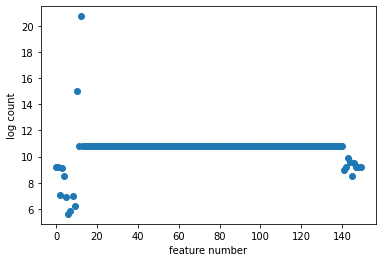

In [23]:
# Plotting data for some intution
plt.scatter(range(150),np.log(np.sum(X, axis=0)))
plt.ylabel('log count')
plt.xlabel('feature number')


# Running our policy in a loop
To test our policy, we can loop over every individual in the population 'X' and decide on the action and observe the outcome

In [10]:
# These are the possbile actions, currently restricted to -1, which is
# No vaccine, and 0, which is a vaccine
action_space = np.array([-1,0,1])
nactions = action_space.shape[0]

# Initializing our policy with the number of actions and
vaccine_policy = Naive(nactions, action_space)

# Here we set our predictive model
vaccine_policy.set_model(BetaBernoulliModel(n_symptoms, nactions))

# Arrays to store the actions and outcomes for each
Y = np.zeros((n_population, n_symptoms+1))
A = np.zeros(n_population)

for t in range(n_population):
    #print("Person nr: ", t)
    a_t = vaccine_policy.get_action(X[t].reshape((1, n_features)))
    # Then you can obtain results for everybody
    y_t = population.vaccinate([t], a_t.reshape((1, 1)))
    # Feed the results back in your policy. This allows you to fit the
    # statistical model you have.
    vaccine_policy.observe(X[t], a_t, y_t)

    # Saving action taken and outcome obtained.
    Y[t] = y_t
    A[t] = a_t


Initialising policy with  3 actions
A = { [-1  0  1] }


In [12]:
def print_pre_statistics(X):
    print(f'Statistic (N={X.shape[0]})')
    for i in range(len(symptom_names)-1):
        print(f'{symptom_names[i].ljust(15)} {X[:, i].sum()}')


[0. 0. 1. ... 0. 1. 1.]


(array([40000.,     0.,     0.,     0.,     0., 40001.,     0.,     0.,
            0., 19999.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

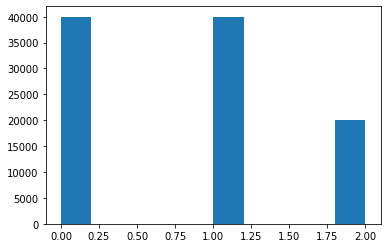

In [13]:
#print_pre_statistics(Y)
print(A)
plt.hist(A)

In [14]:
# Getting model paramters and plotting expectation

a, b = vaccine_policy.model.get_params()
c = a[0]/(a[0] + b[0])
v = a[1]/(a[1] + b[1])


In [15]:
for i in c:
    print(f'{i:.6f}')

0.000012
0.000012
0.000012
0.000012
0.000012
0.000012
0.000012
0.000012
0.000012


In [16]:
for i in v:
    print(f'{i:.6f}')
    

0.000012
0.000012
0.000012
0.000012
0.000012
0.000012
0.000012
0.000012
0.000012


In [25]:
print(np.sum(Y, axis=0))
#plt.scatter(range(150),np.sum(X, axis=0))
print('Accumulated utility for the policy run:', vaccine_policy.get_utility(X, A, Y))



[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Accumulated utility for the policy run: 0.0


# FAIRNESS
Assume we have a set of features $X$, a set of actions taken $A$, and a set of outcomes $Y$. Make a function that accepts these numpy arrays and calculates the equal-op score using this list of sensitive variables.


In [20]:
sensitive_control_variables = ['gender', 'income']

In [ ]:
def equal_op(X, A, Y, Z=sensitive_control_variables):
    scores = np.zeros(len(Z))

    for z in Z:
        